In [21]:
drive_path = 'c:/'
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp
from scipy.stats import kruskal
from scipy.stats import variation
from scipy import signal as sps
import seaborn as sns
import glob
import re

# Detrended peaks

In [3]:
# (pd.read_csv('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\GoodFiles\\160330_3\\44dtnew.txt'))
# badfile=(pd.read_csv('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\GoodFiles\\160330_3\\44dt.txt'))
# rightfile=badfile.iloc[:,1:16]
# rightfile
# rightfile.to_csv('44dtnew.txt')

In [22]:
date='160626_2'
os.chdir('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\GoodFiles\\%s'%date)

In [9]:
#This piece spits out all the peaks from one session in one dataframe
peakdf=pd.DataFrame([])
date='160626_2'
os.chdir('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\GoodFiles\\%s'%date)
for filename in glob.glob('*dt.txt'):
    f=pd.read_csv(filename,nrows=175)
    df=f[[col for col in f.columns if 'G PMT' in col]]
    peak=[]
    for col in df.columns:
        a=df[col]
        firsta=1;
        firstb=24;
        #Figures out if there is a min or max and sees if it passes threshold (3SD)
        if np.absolute(min(a[26:80]))>np.absolute(max(a[26:80])) and np.absolute(min(a[26:80]))>=3*np.std(df[col][firsta:firstb]):
            b=min(a[26:80])
            peak.append(b)
        elif np.absolute(max(a[26:80]))>np.absolute(min(a[26:80]))and np.absolute(max(a[26:80]))>=3*np.std(df[col][firsta:firstb]):
            b=max(a[26:80])
            peak.append(b)
        else:
            b=0
            peak.append(b)
        peaks=pd.DataFrame(peak).T
    peaks.columns=df.columns
    peaks=pd.concat([pd.DataFrame({'Trial':[int(filename.split('dt')[0])]}),peaks],axis=1)
    peakdf=peakdf.append(peaks,ignore_index=True)
peakdf.to_csv('%s_peaks.csv'%date,index=False)

In [6]:
trials=pd.read_csv('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\Analysis\\Odor_Panel\\Odor_Trials.csv')
filerow=trials.loc[trials['File']==date]
odortrials={}
for t in trials.Odor.unique():
    y={t:[int(x) for x in filerow.loc[filerow['Odor'] == t][['T1','T2','T3','T4']].values.tolist()[0]]}
    odortrials.update(y)

In [11]:
#Get average peak across all trials using peakdf dataframe
meandf=pd.DataFrame([])
for key in odortrials:
    odor=odortrials[key]
    mean=[]
    for col in peakdf.loc[peakdf['Trial'].isin(odor)][[col for col in peakdf.loc[peakdf['Trial'].isin(odor)].columns if 'G PMT' in col]]:
        mean.append(peakdf.loc[peakdf['Trial'].isin(odor)][col].mean())
    mean=pd.DataFrame(mean).T
    mean.columns=peakdf.loc[peakdf['Trial'].isin(odor)][[col for col in peakdf.loc[peakdf['Trial'].isin(odor)].columns if 'G PMT' in col]].columns
    meandf=meandf.append(mean)
meandf=meandf.reset_index(drop=True)
meandf.columns=[str(col)+'_'+date for col in meandf.columns]
meandf=pd.concat([pd.DataFrame({'Odor':odortrials.keys()}),meandf],axis=1)
# meandf.to_csv('%s_mean.csv'%date,index=False)

In [8]:
#Get proportion of successful trials
successdf=pd.DataFrame([])
for key in odortrials:
    odor=odortrials[key]
    newdf=peakdf.loc[peakdf['Trial'].isin(odor)]
    s=[]
    for col in peakdf.loc[peakdf['Trial'].isin(odor)][[col for col in peakdf.loc[peakdf['Trial'].isin(odor)].columns if 'G PMT' in col]]:
        s.append(np.divide((newdf.loc[:,col]!=0).sum(),float(len(newdf.loc[:,col]))))
    s=pd.DataFrame(s).T
    s.columns=peakdf.loc[peakdf['Trial'].isin(odor)][[col for col in peakdf.loc[peakdf['Trial'].isin(odor)].columns if 'G PMT' in col]].columns
    successdf=successdf.append(s)
successdf=successdf.reset_index(drop=True)
successdf.columns=[str(col)+'_'+date for col in successdf.columns]
successdf=pd.concat([pd.DataFrame({'Odor':odortrials.keys()}),successdf],axis=1)
successdf.to_csv('%s_success.csv'%date,index=False)

# Detrended integral

In [3]:
# # date='160330_3'
# # os.chdir('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\GoodFiles\\%s'%date)
# #example dataframe
# for filename in 
# df=pd.read_csv('1dt.txt')
# df=df[[col for col in df.columns if 'G PMT' in col]]

In [176]:
temp=pd.DataFrame([])
date='160330_3'
os.chdir('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\GoodFiles\\%s'%date)
#Pull the trials that correspond to specific date/odors
trials=pd.read_csv('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\Analysis\\Odor_Panel\\Odor_Trials.csv')
filerow=trials.loc[trials['File']==date]
odortrials={}
for t in trials.Odor.unique():
    y={t:[int(x) for x in filerow.loc[filerow['Odor'] == t][['T1','T2','T3','T4']].values.tolist()[0]]}
    odortrials.update(y)
#Get the frame rate for a specified date
num=trials.File.unique().tolist().index('%s'%date)
fr=trials.loc[trials['File']==trials.File.unique().tolist()[num]]['FrameRate'].iloc[0]
#Get the integral
intdf=pd.DataFrame([])
for filename in glob.glob('*dt.txt'):
    f=pd.read_csv(filename,nrows=125)
    df=f[[col for col in f.columns if 'G PMT' in col]]
    winstart=np.int(4*fr)
    winend=np.int(12*fr)
    integral=[]
    for col in df.columns:
        a=df[col]
        firsta=1;
        firstb=24;
        #Figures out if there is a min or max and sees if it passes threshold (3SD)
        if np.absolute(min(a[26:80]))>np.absolute(max(a[26:80])) and np.absolute(min(a[26:80]))>=3*np.std(df[col][firsta:firstb]):
            b=sum(df[col][winstart:winend]*(1/fr))
            integral.append(b)
        elif np.absolute(max(a[26:80]))>np.absolute(min(a[26:80]))and np.absolute(max(a[26:80]))>=3*np.std(df[col][firsta:firstb]):
            b=sum(df[col][winstart:winend]*(1/fr))
            integral.append(b)
        else:
            b=0
            integral.append(b)
    integral=pd.DataFrame(integral).T
    integral.columns=df.columns
    integral=pd.concat([pd.DataFrame({'Trial':[int(filename.split('dt')[0])]}),integral],axis=1)
    intdf=intdf.append(integral)
intdf.to_csv('%s_integral.csv'%date,index=False)

In [181]:
#Get average integral across all trials using integral dataframe
meanint=pd.DataFrame([])
for key in odortrials:
    odor=odortrials[key]
    mean=[]
    for col in intdf.loc[intdf['Trial'].isin(odor)][[col for col in intdf.loc[intdf['Trial'].isin(odor)].columns if 'G PMT' in col]]:
        mean.append(intdf.loc[intdf['Trial'].isin(odor)][col].mean())
    mean=pd.DataFrame(mean).T
    mean.columns=intdf.loc[intdf['Trial'].isin(odor)][[col for col in intdf.loc[intdf['Trial'].isin(odor)].columns if 'G PMT' in col]].columns
    meanint=meanint.append(mean)
meanint=meanint.reset_index(drop=True)
meanint.columns=[str(col)+'_'+date for col in meanint.columns]
meanint=pd.concat([pd.DataFrame({'Odor':odortrials.keys()}),meanint],axis=1)
meanint.to_csv('%s_meanint.csv'%date,index=False)

# Detrended baseline

In [24]:
temp=pd.DataFrame([])
date='160330_3'
os.chdir('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\GoodFiles\\%s'%date)
#Pull the trials that correspond to specific date/odors
trials=pd.read_csv('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\Analysis\\Odor_Panel\\Odor_Trials.csv')
filerow=trials.loc[trials['File']==date]
odortrials={}
for t in trials.Odor.unique():
    y={t:[int(x) for x in filerow.loc[filerow['Odor'] == t][['T1','T2','T3','T4']].values.tolist()[0]]}
    odortrials.update(y)
#Get the frame rate for a specified date
num=trials.File.unique().tolist().index('%s'%date)
fr=trials.loc[trials['File']==trials.File.unique().tolist()[num]]['FrameRate'].iloc[0]
#Get baseline
baseline=pd.DataFrame([])
for filename in glob.glob('*dt.txt'):
    f=pd.read_csv(filename,nrows=125)
    df=f[[col for col in f.columns if 'G PMT' in col]]
    winstart=np.int(4*fr)
    winend=np.int(12*fr)
    base=[]
    for col in df.columns:
        a=df[col]
        firsta=1;
        firstb=24;
        b=(df[col][firsta:firstb]).mean()
        base.append(b)
    base=pd.DataFrame(base).T
    base.columns=df.columns
    base=pd.concat([pd.DataFrame({'Trial':[int(filename.split('dt')[0])]}),base],axis=1)
    baseline=baseline.append(base)
baseline.to_csv('%s_baseline.csv'%date,index=False)

In [26]:
#mean baseline
meanbase=pd.DataFrame([])
for key in odortrials:
    odor=odortrials[key]
    mean=[]
    for col in baseline.loc[baseline['Trial'].isin(odor)][[col for col in baseline.loc[baseline['Trial'].isin(odor)].columns if 'G PMT' in col]]:
        mean.append(baseline.loc[baseline['Trial'].isin(odor)][col].mean())
    mean=pd.DataFrame(mean).T
    mean.columns=baseline.loc[baseline['Trial'].isin(odor)][[col for col in baseline.loc[baseline['Trial'].isin(odor)].columns if 'G PMT' in col]].columns
    meanbase=meanbase.append(mean)
meanbase=meanbase.reset_index(drop=True)
meanbase.columns=[str(col)+'_'+date for col in meanbase.columns]
meanbase=pd.concat([pd.DataFrame({'Odor':odortrials.keys()}),meanbase],axis=1)
# meanbase.to_csv('%s_meanbase.csv'%date,index=False)

In [28]:
meanbase

,Odor,G PMT (1)_160330_3,G PMT (2)_160330_3,G PMT (3)_160330_3,G PMT (4)_160330_3,G PMT (5)_160330_3,G PMT (6)_160330_3,G PMT (7)_160330_3,G PMT (8)_160330_3,G PMT (9)_160330_3,G PMT (10)_160330_3,G PMT (11)_160330_3,G PMT (12)_160330_3,G PMT (13)_160330_3,G PMT (14)_160330_3,G PMT (15)_160330_3
0,IAA10,-0.004230,0.000723,-0.000525,0.006939,0.004007,0.004996,0.008156,-0.002754,0.007712,-0.006166,0.001741,-0.003249,-0.000863,-0.001321,0.000379
1,IAA01,0.000210,-0.002284,-0.002584,0.005723,0.000540,-0.000209,0.004656,-0.002402,-0.001625,-0.005141,-0.003696,-0.003886,-0.001328,-0.005061,-0.001324
2,AP,-0.006349,-0.002911,-0.000479,0.000938,-0.003350,-0.002714,-0.002455,-0.003111,-0.002183,-0.000381,-0.002530,-0.005367,-0.001410,-0.003097,-0.002435
3,MS10,-0.003141,-0.003885,-0.003913,-0.003040,-0.001047,0.000144,0.000143,0.000346,-0.002007,-0.002806,-0.002141,-0.003498,-0.001442,-0.005421,-0.003581
4,IAA05,-0.001864,-0.002353,-0.005286,0.002599,-0.001782,-0.000211,0.003648,-0.004936,0.000865,0.003699,-0.000824,-0.003090,-0.002415,-0.004693,-0.000452
5,Hexanal01,-0.005869,-0.003338,-0.003011,-0.000483,0.000115,0.001698,0.000356,0.005437,0.004524,0.004547,-0.003022,-0.004029,0.001947,-0.001096,-0.002302
6,EB,-0.000458,-0.001112,-0.003886,0.004596,-0.000258,0.004115,0.002212,-0.001196,0.003517,-0.000141,-0.003145,-0.001224,-0.004046,-0.006046,0.003135
7,MS01,-0.004528,-0.000533,-0.001770,-0.003275,-0.003056,0.000108,0.000719,-0.003364,-0.002029,0.000888,-0.003760,-0.002115,-0.000040,0.000084,-0.001479
8,PA,-0.002716,-0.004157,-0.007559,0.004096,0.000683,-0.000955,0.002639,-0.000913,-0.002134,-0.000056,0.000548,-0.001705,-0.003881,-0.005284,0.000902
9,MS05,-0.005032,-0.002676,-0.003452,-0.000889,-0.000047,0.000391,0.003618,-0.001625,-0.001405,-0.001851,-0.002419,-0.002895,-0.000864,-0.002235,-0.002714


In [31]:
test=pd.read_csv('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\GoodFiles\\160321_1\\160321_1_baseline.csv')

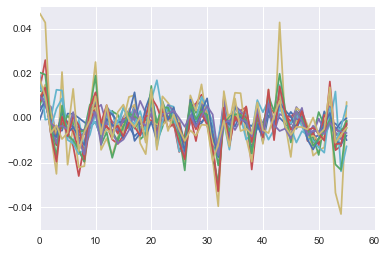

In [37]:
plt.plot(test.iloc[:,1:-1]);

In [40]:
test2=pd.read_csv('C:\\Users\\Annie\\Documents\\Data\\Ca_Imaging\\GoodFiles\\160321_1\\160321_1_meanbase.csv')

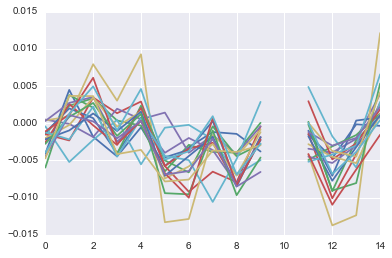

In [43]:
plt.plot(test2.iloc[:,1:]);

In [44]:
test2

,Odor,G PMT (1)_160321_1,G PMT (2)_160321_1,G PMT (3)_160321_1,G PMT (4)_160321_1,G PMT (5)_160321_1,G PMT (6)_160321_1,G PMT (7)_160321_1,G PMT (8)_160321_1,G PMT (9)_160321_1,G PMT (10)_160321_1,G PMT (11)_160321_1,G PMT (12)_160321_1,G PMT (13)_160321_1,G PMT (14)_160321_1,G PMT (15)_160321_1,G PMT (16)_160321_1,G PMT (17)_160321_1,G PMT (18)_160321_1
0,IAA10,-0.004087,-0.001526,-0.001482,0.000489,0.000369,-0.000420,-0.001276,-0.005965,-0.002591,0.000297,-0.001997,-0.001221,-0.002165,-0.002774,-0.001108,-0.004476,-0.004730,-0.003955
1,IAA01,0.004476,0.002345,-0.002319,-0.000092,0.000905,-0.005217,0.001989,0.003781,0.002584,0.002728,-0.000242,-0.002179,-0.000972,0.000850,0.001192,0.001101,0.003673,0.001258
2,AP,-0.001815,0.003352,0.003453,-0.001859,0.007927,-0.002247,0.000683,0.002080,-0.000285,0.003524,0.003432,0.002222,0.001305,0.002724,0.006108,0.000239,0.003637,0.004956
3,MS10,-0.004458,0.000360,0.001343,0.001943,0.003032,0.000446,-0.004047,-0.004107,-0.002922,-0.002472,-0.000458,-0.004485,-0.001046,-0.001706,-0.002829,-0.002033,-0.004153,-0.000977
4,IAA05,-0.000554,-0.000324,0.002913,0.000529,0.009261,-0.005525,0.000741,0.002357,0.002036,0.000283,0.001580,0.000655,0.001541,0.001235,0.000320,0.000303,-0.003588,0.004600
5,Hexanal01,-0.005732,-0.006466,-0.005763,0.001426,-0.013312,-0.000605,-0.004593,-0.005000,-0.005775,-0.003976,-0.007431,-0.004396,-0.007064,-0.009405,-0.006726,-0.006909,-0.007833,-0.004894
6,EB,-0.003239,-0.002909,-0.009212,-0.003973,-0.012870,-0.000227,-0.003570,-0.006612,-0.003417,-0.001987,-0.005810,-0.004965,-0.004418,-0.009557,-0.010010,-0.006434,-0.007575,-0.003771
7,MS01,-0.001182,-0.003854,-0.006513,-0.001613,-0.001627,-0.002185,0.000289,-0.000426,-0.002631,-0.003610,-0.002788,-0.010578,-0.001805,-0.000979,0.000704,-0.002082,-0.003667,0.000940
8,PA,-0.001438,-0.003960,-0.007924,-0.004150,-0.004422,-0.006936,-0.008189,-0.004430,-0.008342,-0.008222,-0.007057,-0.004810,-0.008502,-0.009677,-0.008323,-0.008509,-0.003869,-0.006896
9,MS05,-0.003806,0.000051,-0.000437,-0.000417,-0.000867,-0.004963,-0.002282,-0.002811,-0.001902,-0.001823,-0.001202,0.002865,-0.001916,-0.004612,-0.002189,-0.006551,-0.002967,-0.002752
